# Imports Here

In [ ]:
# Step 1: Mount Google Drive
import cv2
import json
import numpy as np
import os
import random
import re
import tensorflow as tf
import albumentations as A

from collections import Counter
from google.colab import drive
from PIL import Image
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score, roc_auc_score, jaccard_score, hamming_loss
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50V2, InceptionV3, Xception, VGG16, MobileNetV3Large, EfficientNetB0, MobileNetV2
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from typing import Any, Dict, List, Tuple


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read The Files

In [ ]:
# === PATHS ===
videos_path = "/content/drive/MyDrive/Project/cholect50-challenge-val/videos"
labels_path = "/content/drive/MyDrive/Project/cholect50-challenge-val/labels"
label_map_file = "/content/drive/MyDrive/Project/cholect50-challenge-val/label_mapping.txt"

In [ ]:
phase_mapping = {
    '0': 'preparation',
    '1': 'carlot-triangle-dissection',
    '2': 'clipping-and-cutting',
    '3': 'gallbladder-dissection',
    '4': 'gallbladder-packaging',
    '5': 'cleaning-and-coagulation',
    '6': 'gallbladder-extraction'
}

X = []
Y = []

# Loop through all videos
for vid_folder in sorted(os.listdir(videos_path)):
    vid_path = os.path.join(videos_path, vid_folder)

    # Skip non-folders
    if not os.path.isdir(vid_path):
        continue

    # Corresponding label JSON
    label_file = f"{vid_folder}.json"
    label_path = os.path.join(labels_path, label_file)

    if not os.path.exists(label_path):
        print(f"Warning: {label_path} not found, skipping {vid_folder}")
        continue

    # Load JSON labels
    with open(label_path, 'r') as f:
        data = json.load(f)

    # Build a mapping of frame_number -> phase_id
    annotations = data['annotations']
    frame_phase = {}
    for frame_id, triplets in annotations.items():
        frame_number = int(frame_id)
        if len(triplets) > 0:
            # Phase ID is at index 14 in triplet vector
            phase_id = triplets[0][14]
        else:
            phase_id = 0  # default to 0 if no triplet
        frame_phase[frame_number] = phase_id

    # Process all frame images
    frame_files = sorted([f for f in os.listdir(vid_path) if f.endswith('.png')])
    for frame_file in frame_files:
        # Extract leading number from filename (handles '000030 (1).png')
        match = re.match(r"(\d+)", frame_file)
        if match:
            frame_number = int(match.group(1))
        else:
            continue  # skip invalid filenames

        phase_id = frame_phase.get(frame_number, 0)

        # Read image
        img_path = os.path.join(vid_path, frame_file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # Resize and convert to RGB
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        X.append(img)
        Y.append(phase_id)

# Convert lists to numpy arrays
X = np.array(X, dtype=np.float32) / 255.0  # normalize
Y = np.array(Y, dtype=np.int64)

print(f"Total frames processed: {len(X)}")
print(f"X shape: {X.shape}, Y shape: {Y.shape}")

Total frames processed: 1318
X shape: (1318, 224, 224, 3), Y shape: (1318,)


In [ ]:
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomCrop(height=200, width=200, p=0.5),
    A.Resize(height=224, width=224)  # make sure final size is correct
])

# Target minimum per class
MIN_SAMPLES = 300

X_balanced, Y_balanced = [], []

# Count original distribution
counts = Counter(Y)
print("Original class distribution:", counts)

# Loop through each class
for cls in np.unique(Y):
    cls_indices = np.where(Y == cls)[0]
    X_cls = X[cls_indices]
    Y_cls = Y[cls_indices]

    # Always keep originals
    X_balanced.extend(X_cls)
    Y_balanced.extend(Y_cls)

    # How many more needed?
    n_to_add = max(0, MIN_SAMPLES - len(X_cls))

    if n_to_add > 0:
        print(f"Augmenting class {cls} with {n_to_add} new samples...")
        for _ in tqdm(range(n_to_add)):
            idx = np.random.randint(0, len(X_cls))
            img = X_cls[idx]

            # Albumentations expects uint8
            img = (img * 255).astype(np.uint8)

            aug_img = augment(image=img)["image"]

            # Scale back to [0,1]
            aug_img = aug_img.astype(np.float32) / 255.0

            X_balanced.append(aug_img)
            Y_balanced.append(cls)

# Convert to arrays
X_balanced = np.array(X_balanced)
Y_balanced = np.array(Y_balanced)

# Check new distribution
new_counts = Counter(Y_balanced)
print("New class distribution:", new_counts)
print("Final shapes -> X:", X_balanced.shape, ", Y:", Y_balanced.shape)

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Original class distribution: Counter({np.int64(3): 338, np.int64(2): 282, np.int64(1): 217, np.int64(0): 149, np.int64(5): 143, np.int64(4): 115, np.int64(6): 74})
Augmenting class 0 with 151 new samples...


100%|██████████| 151/151 [00:00<00:00, 820.53it/s]


Augmenting class 1 with 83 new samples...


100%|██████████| 83/83 [00:00<00:00, 921.53it/s]


Augmenting class 2 with 18 new samples...


100%|██████████| 18/18 [00:00<00:00, 855.11it/s]


Augmenting class 4 with 185 new samples...


100%|██████████| 185/185 [00:00<00:00, 941.30it/s]


Augmenting class 5 with 157 new samples...


100%|██████████| 157/157 [00:00<00:00, 905.84it/s]


Augmenting class 6 with 226 new samples...


100%|██████████| 226/226 [00:00<00:00, 912.30it/s]


New class distribution: Counter({np.int64(3): 338, np.int64(0): 300, np.int64(1): 300, np.int64(2): 300, np.int64(4): 300, np.int64(5): 300, np.int64(6): 300})
Final shapes -> X: (2138, 224, 224, 3) , Y: (2138,)


In [ ]:
# Print new class distribution
counter_new = Counter(Y_balanced)
print("\nNew class distribution:")
for cls, count in counter_new.items():
    print(f"Phase {cls}: {count} frames")

X_aug = np.array(X_balanced)
Y_aug = np.array(Y_balanced)
print(f"\nTotal frames after augmentation: {len(Y_aug)}")
print(f"X_aug shape: {X_aug.shape}, Y_aug shape: {Y_aug.shape}")


New class distribution:
Phase 0: 300 frames
Phase 1: 300 frames
Phase 2: 300 frames
Phase 3: 338 frames
Phase 4: 300 frames
Phase 5: 300 frames
Phase 6: 300 frames

Total frames after augmentation: 2138
X_aug shape: (2138, 224, 224, 3), Y_aug shape: (2138,)


In [ ]:
import tensorflow as tf
# Stratified split
from sklearn.model_selection import train_test_split
trainX, tempX, trainY, tempY = train_test_split(X_aug, Y_aug, test_size=0.2, stratify=Y_aug, random_state=42)
valX, testX, valY, testY = train_test_split(tempX, tempY, test_size=0.5, stratify=tempY, random_state=42)

print("Train:", trainX.shape, trainY.shape)
print("Val:", valX.shape, valY.shape)
print("Test:", testX.shape, testY.shape)

Train: (1710, 224, 224, 3) (1710,)
Val: (214, 224, 224, 3) (214,)
Test: (214, 224, 224, 3) (214,)


In [ ]:
import tensorflow as tf

BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

def make_dataset(X, Y, batch_size=BATCH_SIZE, training=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    if training:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size).prefetch(AUTOTUNE)
    return dataset

train_ds = make_dataset(trainX, trainY, training=True)
val_ds   = make_dataset(valX, valY, training=False)
test_ds  = make_dataset(testX, testY, training=False)

In [ ]:
IMG_SIZE = 224
drop_rate = 0.3
num_heads = 4  # multihead attention heads
embed_dim = 128  # feature dimension for attention
num_instruments = 7
epoch_size = 20

def build_model_with_backbone(backbone_model, input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_instruments):
    """
    Builds a model with a specified backbone, Multi-Head Attention, and dense layers.

    Args:
        backbone_model: The Keras application model class (e.g., MobileNetV2, ResNet50V2).
        input_shape: The input shape of the images.
        num_classes: The number of output classes.

    Returns:
        A Keras Model.
    """
    # === Backbone ===
    # Ensure include_top is False to get the convolutional base
    # Handle potential differences in input_shape argument name
    try:
        base = backbone_model(include_top=False, weights='imagenet', input_shape=input_shape, pooling=None)
    except TypeError:
         base = backbone_model(include_top=False, weights='imagenet', input_shape=input_shape) # Some models don't have pooling arg


    base.trainable = False  # Freeze backbone initially

    inp = layers.Input(shape=input_shape)
    x = base(inp)

    # Flatten spatial dimensions for attention: (batch, seq_len, channels)
    # Handle cases where base output might be flattened already or have different ranks
    if len(x.shape) == 4:
        b, h, w, c = x.shape
        x_flat = layers.Reshape((-1, c))(x)  # seq_len = h*w
    elif len(x.shape) == 3:
         x_flat = x # Assume already (batch, seq_len, channels)
    else:
         raise ValueError(f"Unexpected backbone output shape: {x.shape}")


    # === Multi-Head Attention ===
    # Adjust key_dim if embed_dim is larger than backbone channels
    attention_key_dim = min(embed_dim, x_flat.shape[-1])
    attn_out = layers.MultiHeadAttention(num_heads=num_heads, key_dim=attention_key_dim)(x_flat, x_flat)
    attn_out = layers.GlobalAveragePooling1D()(attn_out)

    # === Dense Head ===
    x = layers.Dropout(drop_rate)(attn_out)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(drop_rate)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)  # Changed activation to softmax for multi-class

    model = models.Model(inputs=inp, outputs=out)
    return model

# Example usage:
# model_resnet = build_model_with_backbone(ResNet50V2)
# model_inception = build_model_with_backbone(InceptionV3)
# model_xception = build_model_with_backbone(Xception)
# model_vgg16 = build_model_with_backbone(VGG16)
# model_mobilenetv3 = build_model_with_backbone(MobileNetV3Large)
# model_efficientnet = build_model_with_backbone(EfficientNetB0)

print("Functions to build models with different backbones created.")

Functions to build models with different backbones created.


In [ ]:
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def calculate_multi_class_metrics(model: Any, test_ds: Any, phase_mapping: Dict[int, str]) -> Dict[str, Any]:
    """
    Calculates standard multi-class metrics and returns them along with the classification report.
    """

    print("Collecting true labels and generating predictions...")
    # Get true labels and predictions
    y_true = np.concatenate([y for _, y in test_ds], axis=0)
    y_probs = model.predict(test_ds)
    y_pred = np.argmax(y_probs, axis=1) # Get predicted class indices


    # If y_true is one-hot encoded, convert back to integer labels
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:
        y_true = np.argmax(y_true, axis=1)

    # ----------------------------
    # Calculate standard multi-class metrics
    # ----------------------------
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)

    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)


    # Classification report
    report = classification_report(y_true, y_pred, target_names=list(phase_mapping.values()), output_dict=True, zero_division=0)


    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(phase_mapping.values()), yticklabels=list(phase_mapping.values()))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


    # ----------------------------
    # Print results
    # ----------------------------
    print("\n=== Multi-Class Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 (Macro): {f1_macro:.4f}, Precision (Macro): {precision_macro:.4f}, Recall (Macro): {recall_macro:.4f}")
    print(f"F1 (Weighted): {f1_weighted:.4f}, Precision (Weighted): {precision_weighted:.4f}, Recall (Weighted): {recall_weighted:.4f}")
    # Print classification report from the dictionary output
    print("\nClassification Report:\n", json.dumps(report, indent=4))


    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_weighted': f1_weighted,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'classification_report': report,
        'confusion_matrix': cm
    }

In [ ]:
model = build_model_with_backbone(MobileNetV2)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 49, 1280)  │          0 │ mobilenetv2_1.00… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 1280)  │  2,624,256 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    163,968 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 7)         │        903 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,047,111 (19.25 MB)

 Trainable params: 2,789,127 (10.64 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model_backbones = ['ResNet50V2', 'InceptionV3', 'Xception', 'VGG16', 'MobileNetV3Large', 'EfficientNetB0', 'MobileNetV2']
# model_backbones = ['ResNet50V2']


--- Processing Model: ResNet50V2 ---
Building model...
Model ResNet50V2 built successfully.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2          │ (None, 7, 7,      │ 23,564,800 │ input_layer_3[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 49, 2048)  │          0 │ resnet50v2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 2048)  │  4,197,888 │ reshape_1[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    262,272 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 7)         │        903 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,025,863 (106.91 MB)

 Trainable params: 4,461,063 (17.02 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Trainable parameters for ResNet50V2: 4461063
Compiling model...
Model compiled successfully.
Training model...
Model ResNet50V2 trained successfully.
Evaluating model on test set...
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 356ms/step


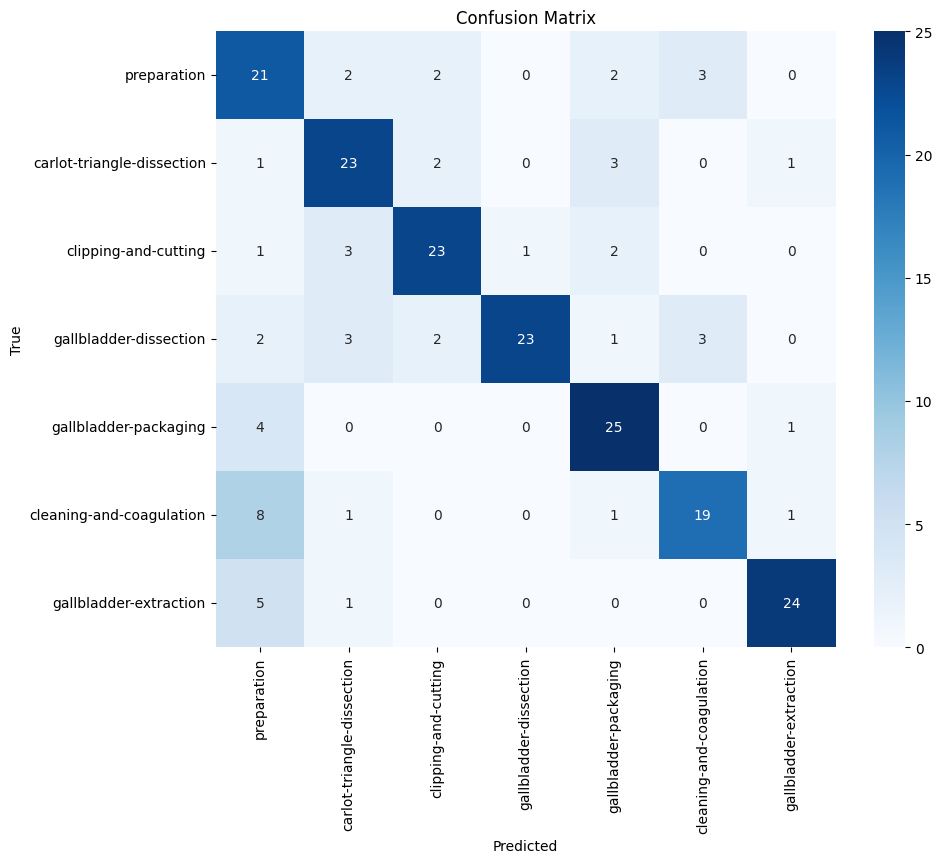


=== Multi-Class Metrics ===
Accuracy: 0.7383
F1 (Macro): 0.7429, Precision (Macro): 0.7618, Recall (Macro): 0.7395
F1 (Weighted): 0.7439, Precision (Weighted): 0.7655, Recall (Weighted): 0.7383

Classification Report:
 {
    "preparation": {
        "precision": 0.5,
        "recall": 0.7,
        "f1-score": 0.5833333333333334,
        "support": 30.0
    },
    "carlot-triangle-dissection": {
        "precision": 0.696969696969697,
        "recall": 0.7666666666666667,
        "f1-score": 0.7301587301587301,
        "support": 30.0
    },
    "clipping-and-cutting": {
        "precision": 0.7931034482758621,
        "recall": 0.7666666666666667,
        "f1-score": 0.7796610169491526,
        "support": 30.0
    },
    "gallbladder-dissection": {
        "precision": 0.9583333333333334,
        "recall": 0.6764705882352942,
        "f1-score": 0.7931034482758621,
        "support": 34.0
    },
    "gallbladder-packaging": {
        "precision": 0.7352941176470589,
        "recall": 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_v3        │ (None, 5, 5,      │ 21,802,784 │ input_layer_1[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 25, 2048)  │          0 │ inception_v3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 25, 2048)  │  4,197,888 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    262,272 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 7)         │        903 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,263,847 (100.19 MB)

 Trainable params: 4,461,063 (17.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Trainable parameters for InceptionV3: 4461063
Compiling model...
Model compiled successfully.
Training model...
Model InceptionV3 trained successfully.
Evaluating model on test set...
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 572ms/step


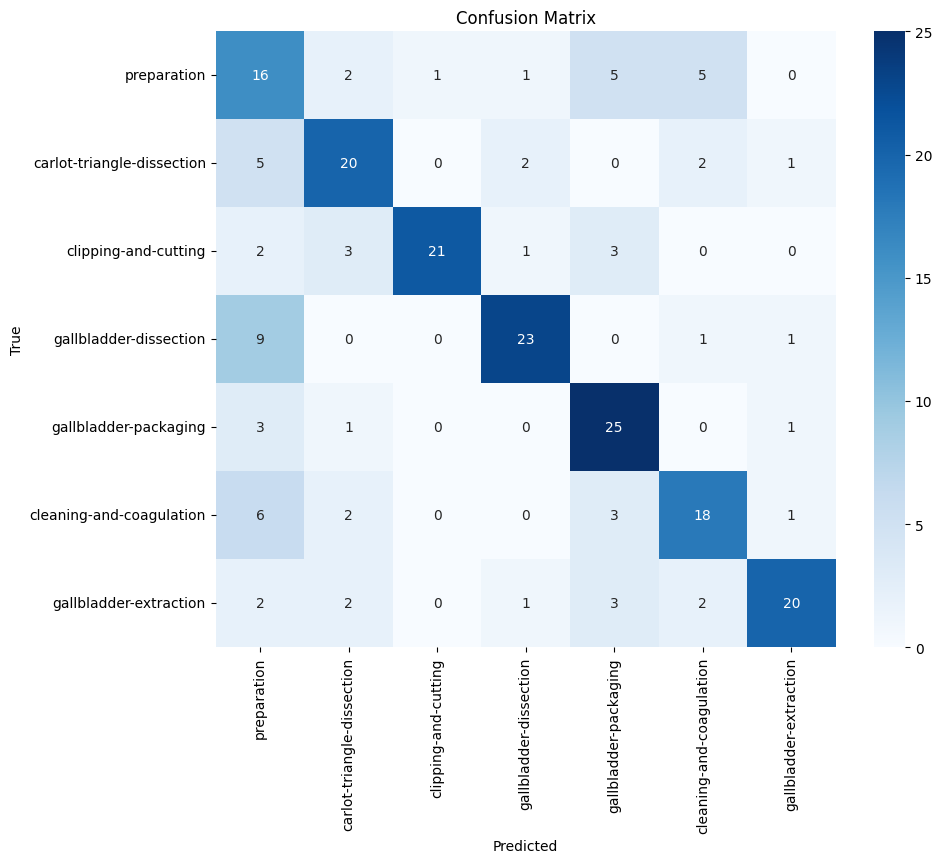


=== Multi-Class Metrics ===
Accuracy: 0.6682
F1 (Macro): 0.6772, Precision (Macro): 0.7046, Recall (Macro): 0.6681
F1 (Weighted): 0.6785, Precision (Weighted): 0.7067, Recall (Weighted): 0.6682

Classification Report:
 {
    "preparation": {
        "precision": 0.37209302325581395,
        "recall": 0.5333333333333333,
        "f1-score": 0.4383561643835616,
        "support": 30.0
    },
    "carlot-triangle-dissection": {
        "precision": 0.6666666666666666,
        "recall": 0.6666666666666666,
        "f1-score": 0.6666666666666666,
        "support": 30.0
    },
    "clipping-and-cutting": {
        "precision": 0.9545454545454546,
        "recall": 0.7,
        "f1-score": 0.8076923076923077,
        "support": 30.0
    },
    "gallbladder-dissection": {
        "precision": 0.8214285714285714,
        "recall": 0.6764705882352942,
        "f1-score": 0.7419354838709677,
        "support": 34.0
    },
    "gallbladder-packaging": {
        "precision": 0.6410256410256411,
 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xception            │ (None, 7, 7,      │ 20,861,480 │ input_layer_1[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 49, 2048)  │          0 │ xception[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 2048)  │  4,197,888 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    262,272 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 7)         │        903 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,322,543 (96.60 MB)

 Trainable params: 4,461,063 (17.02 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

Trainable parameters for Xception: 4461063
Compiling model...
Model compiled successfully.
Training model...
Model Xception trained successfully.
Evaluating model on test set...
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step


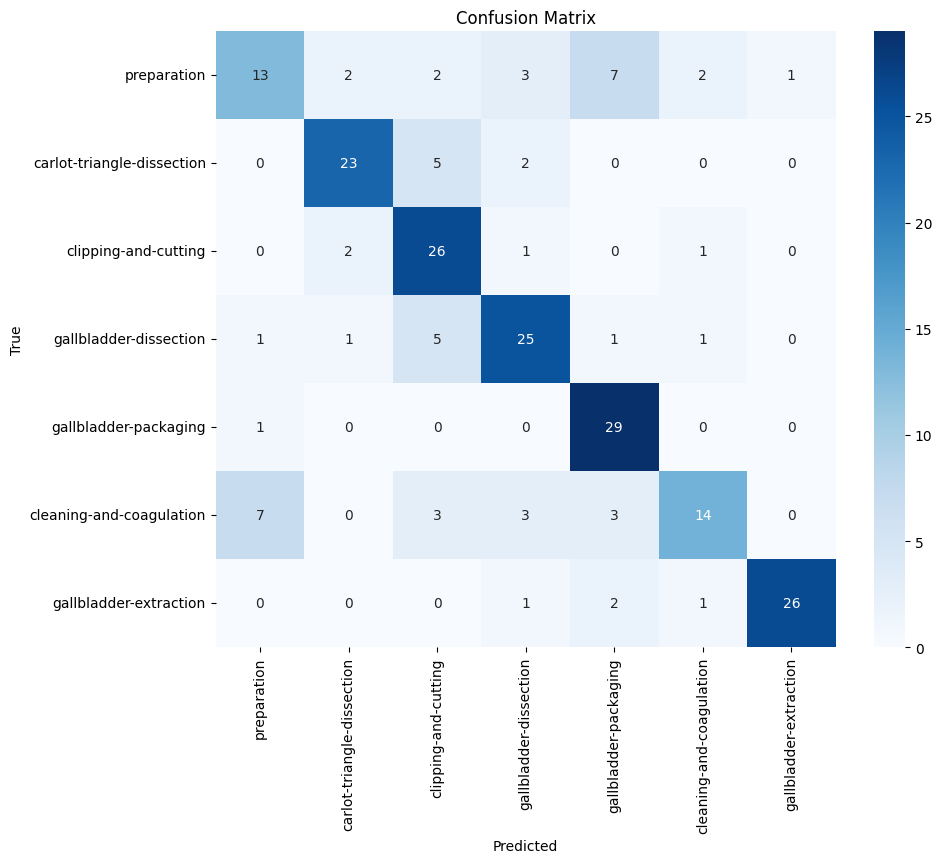


=== Multi-Class Metrics ===
Accuracy: 0.7290
F1 (Macro): 0.7199, Precision (Macro): 0.7359, Recall (Macro): 0.7289
F1 (Weighted): 0.7200, Precision (Weighted): 0.7355, Recall (Weighted): 0.7290

Classification Report:
 {
    "preparation": {
        "precision": 0.5909090909090909,
        "recall": 0.43333333333333335,
        "f1-score": 0.5,
        "support": 30.0
    },
    "carlot-triangle-dissection": {
        "precision": 0.8214285714285714,
        "recall": 0.7666666666666667,
        "f1-score": 0.7931034482758621,
        "support": 30.0
    },
    "clipping-and-cutting": {
        "precision": 0.6341463414634146,
        "recall": 0.8666666666666667,
        "f1-score": 0.7323943661971831,
        "support": 30.0
    },
    "gallbladder-dissection": {
        "precision": 0.7142857142857143,
        "recall": 0.7352941176470589,
        "f1-score": 0.7246376811594203,
        "support": 34.0
    },
    "gallbladder-packaging": {
        "precision": 0.6904761904761905,
 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 49, 512)   │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 512)   │  1,050,624 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     65,664 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 7)         │        903 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,831,879 (60.39 MB)

 Trainable params: 1,117,191 (4.26 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Trainable parameters for VGG16: 1117191
Compiling model...
Model compiled successfully.
Training model...
Model VGG16 trained successfully.
Evaluating model on test set...
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step


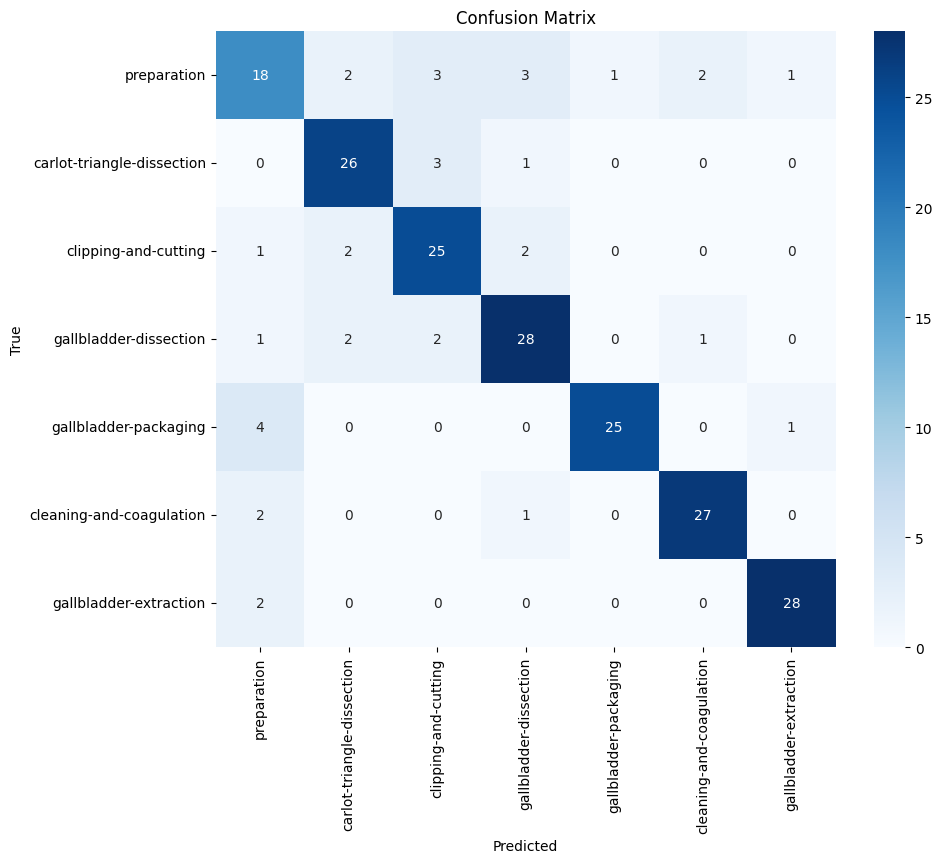


=== Multi-Class Metrics ===
Accuracy: 0.8271
F1 (Macro): 0.8273, Precision (Macro): 0.8297, Recall (Macro): 0.8272
F1 (Weighted): 0.8270, Precision (Weighted): 0.8291, Recall (Weighted): 0.8271

Classification Report:
 {
    "preparation": {
        "precision": 0.6428571428571429,
        "recall": 0.6,
        "f1-score": 0.6206896551724138,
        "support": 30.0
    },
    "carlot-triangle-dissection": {
        "precision": 0.8125,
        "recall": 0.8666666666666667,
        "f1-score": 0.8387096774193549,
        "support": 30.0
    },
    "clipping-and-cutting": {
        "precision": 0.7575757575757576,
        "recall": 0.8333333333333334,
        "f1-score": 0.7936507936507936,
        "support": 30.0
    },
    "gallbladder-dissection": {
        "precision": 0.8,
        "recall": 0.8235294117647058,
        "f1-score": 0.8115942028985508,
        "support": 34.0
    },
    "gallbladder-packaging": {
        "precision": 0.9615384615384616,
        "recall": 0.833333333

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MobileNetV3Large    │ (None, 7, 7, 960) │  2,996,352 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 49, 960)   │          0 │ MobileNetV3Large… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 960)   │  1,968,576 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 960)       │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 960)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    123,008 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 7)         │        903 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,088,839 (19.41 MB)

 Trainable params: 2,092,487 (7.98 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

Trainable parameters for MobileNetV3Large: 2092487
Compiling model...
Model compiled successfully.
Training model...
Model MobileNetV3Large trained successfully.
Evaluating model on test set...
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 506ms/step


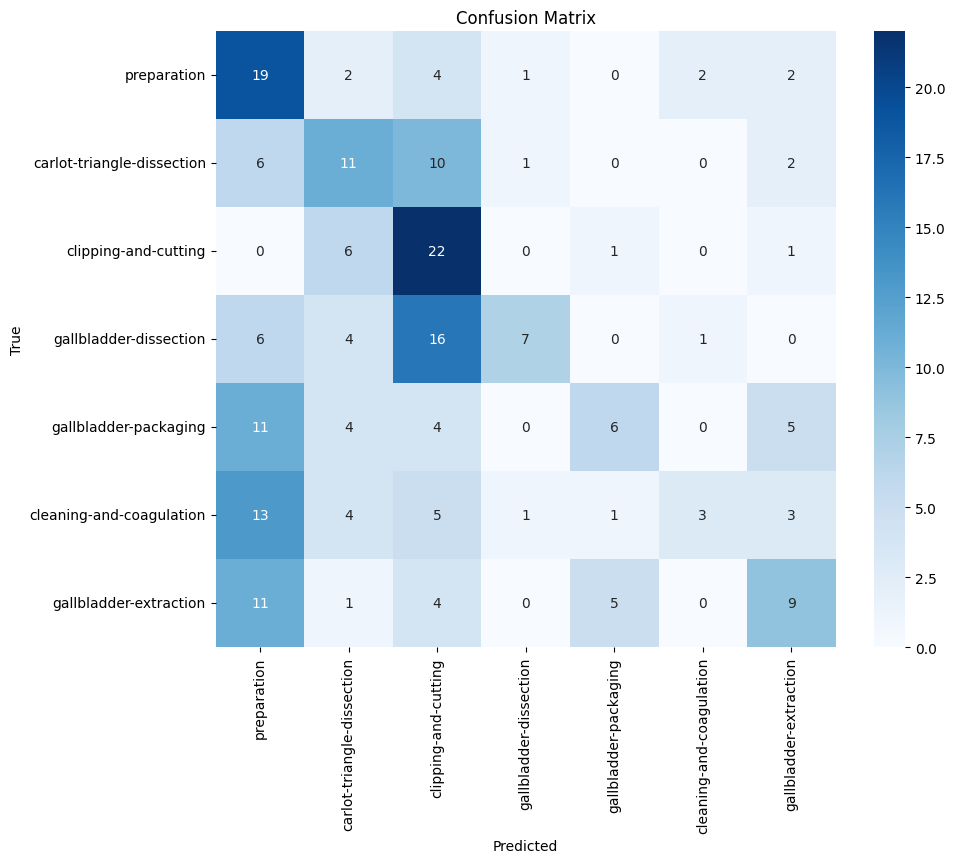


=== Multi-Class Metrics ===
Accuracy: 0.3598
F1 (Macro): 0.3320, Precision (Macro): 0.4344, Recall (Macro): 0.3627
F1 (Weighted): 0.3317, Precision (Weighted): 0.4394, Recall (Weighted): 0.3598

Classification Report:
 {
    "preparation": {
        "precision": 0.2878787878787879,
        "recall": 0.6333333333333333,
        "f1-score": 0.3958333333333333,
        "support": 30.0
    },
    "carlot-triangle-dissection": {
        "precision": 0.34375,
        "recall": 0.36666666666666664,
        "f1-score": 0.3548387096774194,
        "support": 30.0
    },
    "clipping-and-cutting": {
        "precision": 0.3384615384615385,
        "recall": 0.7333333333333333,
        "f1-score": 0.4631578947368421,
        "support": 30.0
    },
    "gallbladder-dissection": {
        "precision": 0.7,
        "recall": 0.20588235294117646,
        "f1-score": 0.3181818181818182,
        "support": 34.0
    },
    "gallbladder-packaging": {
        "precision": 0.46153846153846156,
        "r

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 49, 1280)  │          0 │ efficientnetb0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 1280)  │  2,624,256 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    163,968 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 7)         │        903 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,838,698 (26.09 MB)

 Trainable params: 2,789,127 (10.64 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Trainable parameters for EfficientNetB0: 2789127.0
Compiling model...
Model compiled successfully.
Training model...
Model EfficientNetB0 trained successfully.
Evaluating model on test set...
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 606ms/step


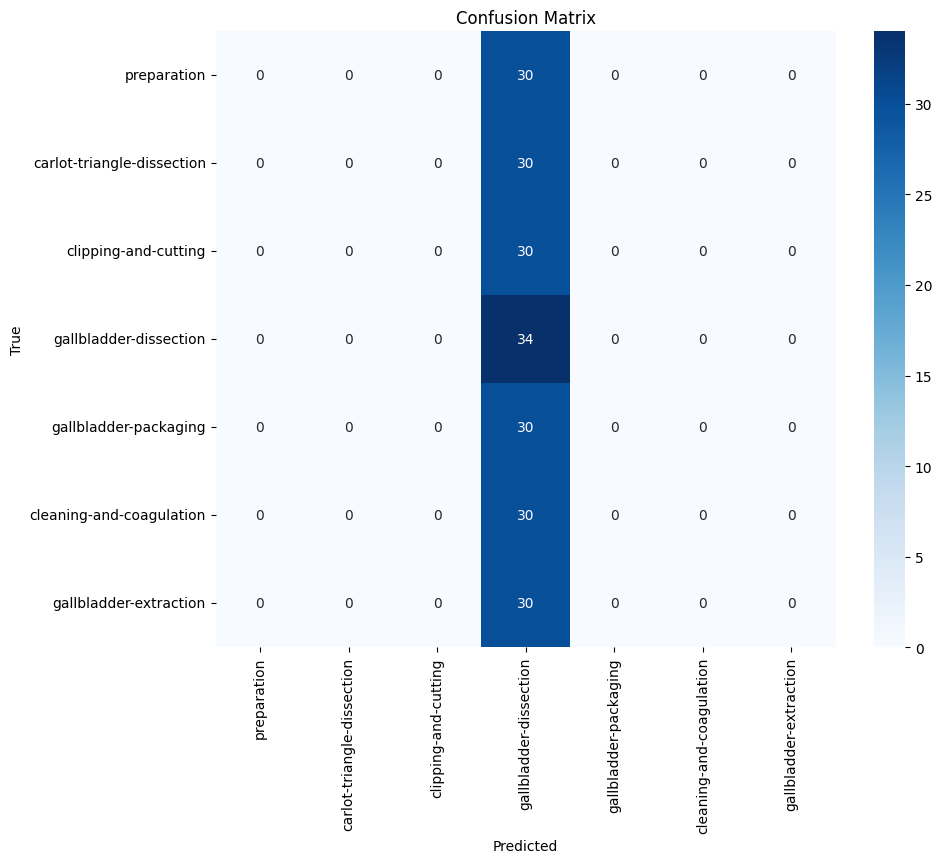


=== Multi-Class Metrics ===
Accuracy: 0.1589
F1 (Macro): 0.0392, Precision (Macro): 0.0227, Recall (Macro): 0.1429
F1 (Weighted): 0.0436, Precision (Weighted): 0.0252, Recall (Weighted): 0.1589

Classification Report:
 {
    "preparation": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 30.0
    },
    "carlot-triangle-dissection": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 30.0
    },
    "clipping-and-cutting": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 30.0
    },
    "gallbladder-dissection": {
        "precision": 0.1588785046728972,
        "recall": 1.0,
        "f1-score": 0.27419354838709675,
        "support": 34.0
    },
    "gallbladder-packaging": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 30.0
    },
    "cleaning-and-coagulation": {
        "precision": 0.0,
        "rec

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 49, 1280)  │          0 │ mobilenetv2_1.00… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 1280)  │  2,624,256 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    163,968 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 7)         │        903 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,047,111 (19.25 MB)

 Trainable params: 2,789,127 (10.64 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Trainable parameters for MobileNetV2: 2789127
Compiling model...
Model compiled successfully.
Training model...
Model MobileNetV2 trained successfully.
Evaluating model on test set...
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 447ms/step


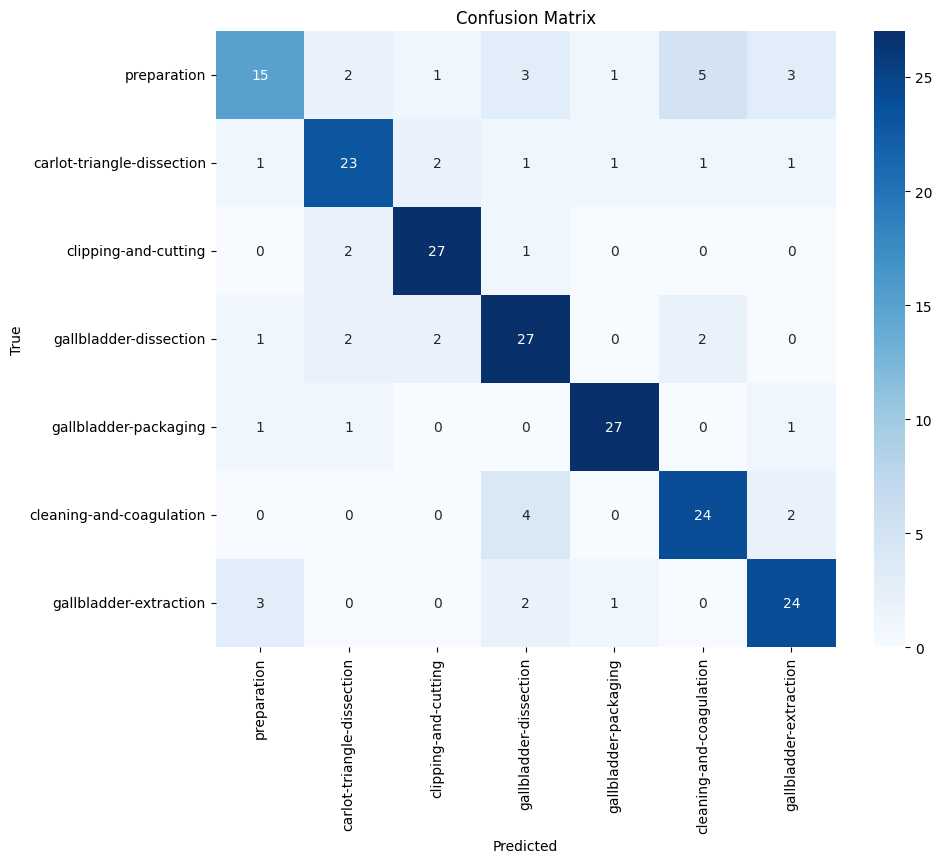


=== Multi-Class Metrics ===
Accuracy: 0.7804
F1 (Macro): 0.7767, Precision (Macro): 0.7799, Recall (Macro): 0.7801
F1 (Weighted): 0.7762, Precision (Weighted): 0.7786, Recall (Weighted): 0.7804

Classification Report:
 {
    "preparation": {
        "precision": 0.7142857142857143,
        "recall": 0.5,
        "f1-score": 0.5882352941176471,
        "support": 30.0
    },
    "carlot-triangle-dissection": {
        "precision": 0.7666666666666667,
        "recall": 0.7666666666666667,
        "f1-score": 0.7666666666666667,
        "support": 30.0
    },
    "clipping-and-cutting": {
        "precision": 0.84375,
        "recall": 0.9,
        "f1-score": 0.8709677419354839,
        "support": 30.0
    },
    "gallbladder-dissection": {
        "precision": 0.7105263157894737,
        "recall": 0.7941176470588235,
        "f1-score": 0.75,
        "support": 34.0
    },
    "gallbladder-packaging": {
        "precision": 0.9,
        "recall": 0.9,
        "f1-score": 0.9,
        "

In [ ]:
# List to store evaluation results for each model
all_results = []

# Iterate through the list of model backbones
for backbone_name in model_backbones:
    print(f"\n--- Processing Model: {backbone_name} ---")

    # Step 3: Build model
    print("Building model...")
    try:
        backbone_class = globals()[backbone_name]
        model = build_model_with_backbone(backbone_class)
        print(f"Model {backbone_name} built successfully.")
        model.summary()

        # Get trainable parameters
        trainable_params = model.count_params() - sum([np.prod(x.shape) for x in model.non_trainable_weights])
        print(f"Trainable parameters for {backbone_name}: {trainable_params}")


    except Exception as e:
        print(f"Error building model {backbone_name}: {e}")
        continue  # Skip to the next backbone

    # Step 4: Compile model
    print("Compiling model...")
    try:
        # Use the focal loss with class weights and PR AUC metric
        # loss_fn = focal_loss_with_class_weights(class_weights, gamma=2.0, alpha=0.25)
        model.compile(
            optimizer=Adam(learning_rate=1e-3),
            loss='sparse_categorical_crossentropy',  # integer labels 0..6
            metrics=['accuracy'] # Changed metric to accuracy for multi-class
        )
        print("Model compiled successfully.")
    except Exception as e:
        print(f"Error compiling model {backbone_name}: {e}")
        del model # Free up memory
        continue # Skip to the next backbone


    # Step 5: Train model
    print("Training model...")
    try:
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epoch_size,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
            ],
            verbose=0 # Suppress verbose output during loop
        )
        print(f"Model {backbone_name} trained successfully.")
    except Exception as e:
        print(f"Error training model {backbone_name}: {e}")
        del model # Free up memory
        continue # Skip to the next backbone


    # Step 6: Evaluate model
    print("Evaluating model on test set...")
    try:
        # Replace the multi-label evaluation with multi-class evaluation
        test_results = calculate_multi_class_metrics(model, test_ds, phase_mapping)

        # Store the results
        result_entry = {
            'model': backbone_name,
            'accuracy': test_results['accuracy'],
            'f1_macro': test_results['f1_macro'],
            'precision_macro': test_results['precision_macro'],
            'recall_macro': test_results['recall_macro'],
            'f1_weighted': test_results['f1_weighted'],
            'precision_weighted': test_results['precision_weighted'],
            'recall_weighted': test_results['recall_weighted'],
            'classification_report': json.dumps(test_results['classification_report']), # Store report as JSON string
            'trainable_params': trainable_params # Add trainable params to results
        }
        all_results.append(result_entry)

        # Step 7: Save the trained model
        model_save_path = f"/content/drive/MyDrive/Project/surgical_phase_recognition_model_{backbone_name}.keras"
        model.save(model_save_path)
        print(f"Model saved to: {model_save_path}")

    except Exception as e:
        print(f"Error evaluating model {backbone_name}: {e}")


    # Clean up for the next iteration to free up memory
    del model
    tf.keras.backend.clear_session()
    print(f"Finished processing {backbone_name}. Memory cleared.")

print("\n--- All models processed. ---")

# Save all results to a CSV file
results_df = pd.DataFrame(all_results)
results_csv_path = "/content/drive/MyDrive/Project/surgical_phase_recognition_model_evaluation_results.csv"
results_df.to_csv(results_csv_path, index=False)
print(f"\nEvaluation results saved to {results_csv_path}")

✅ Evaluation results loaded from: /content/drive/MyDrive/Project/surgical_phase_recognition_model_evaluation_results.csv
Index(['model', 'accuracy', 'f1_macro', 'precision_macro', 'recall_macro',
       'f1_weighted', 'precision_weighted', 'recall_weighted',
       'classification_report', 'trainable_params'],
      dtype='object')


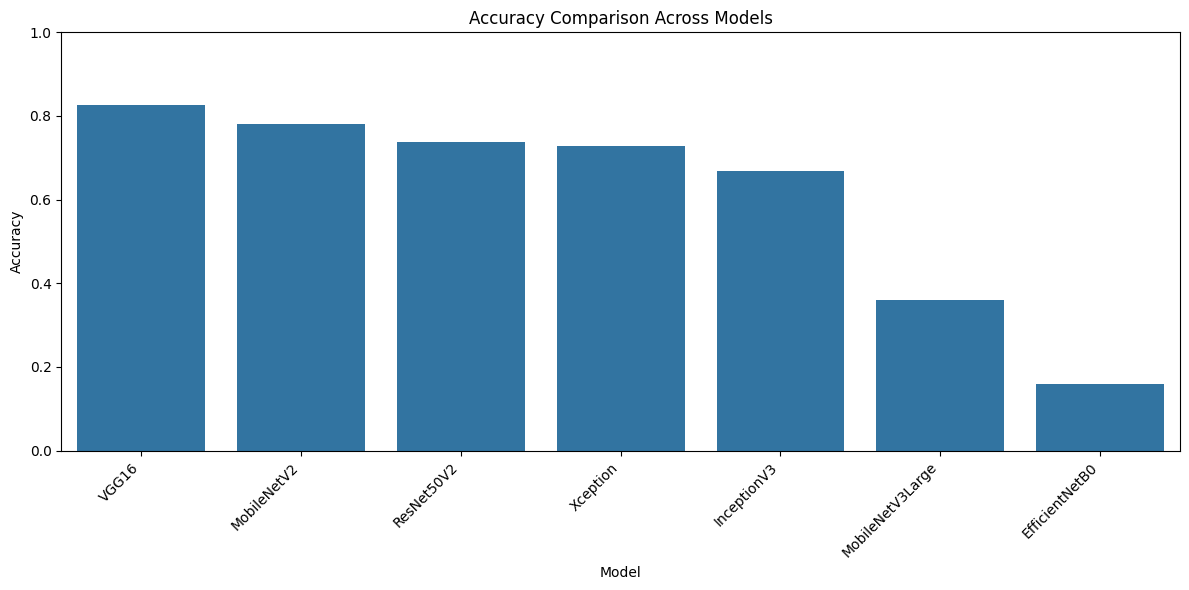

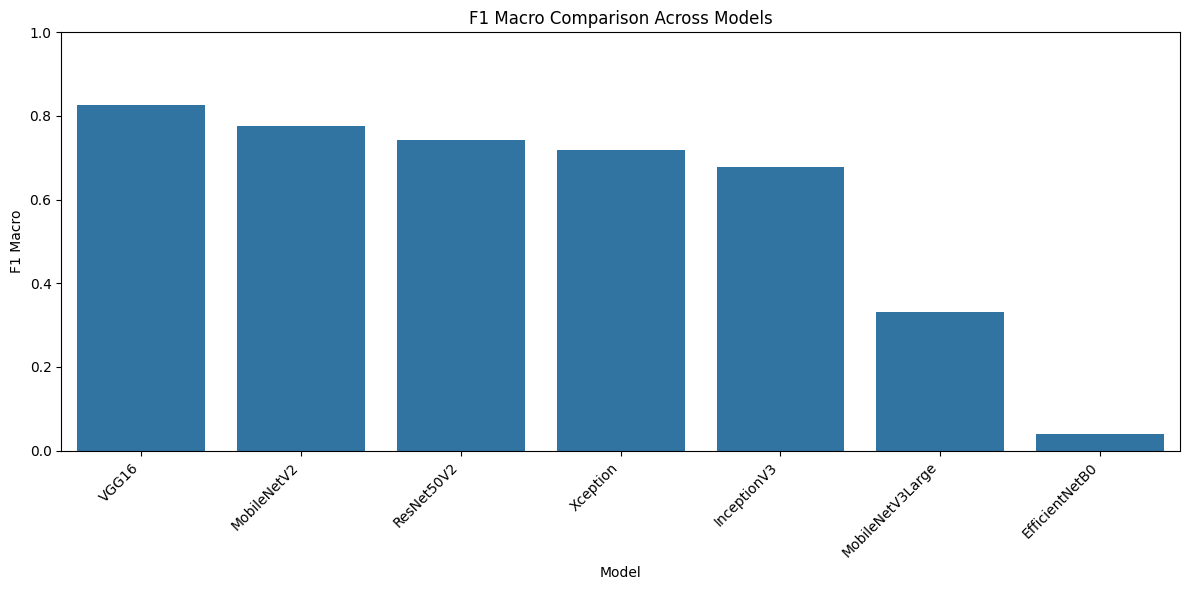

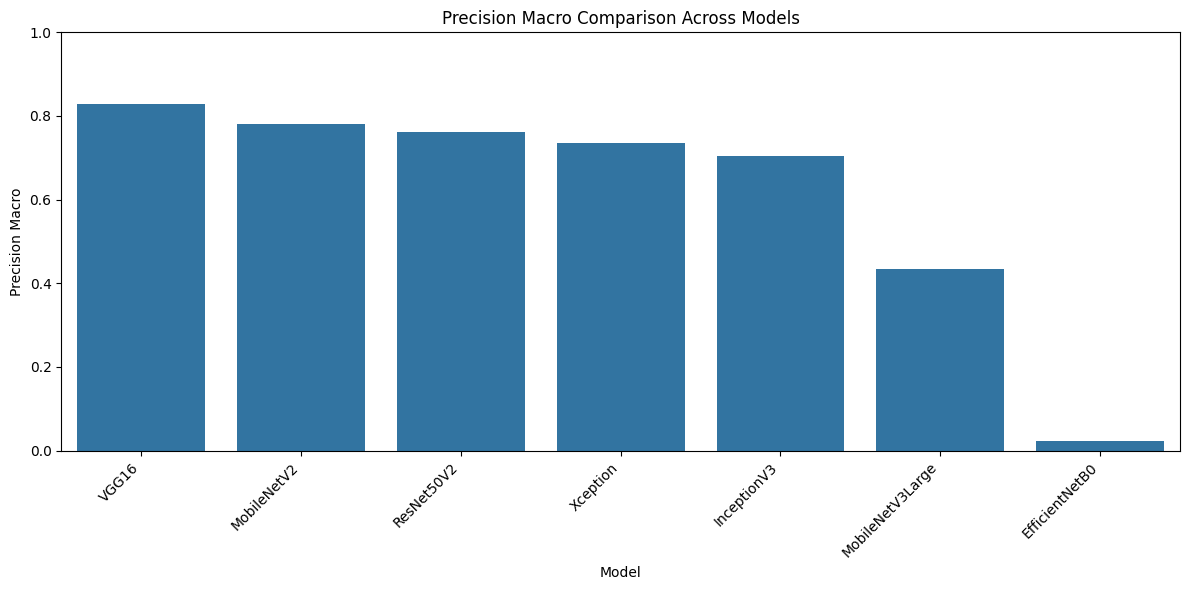

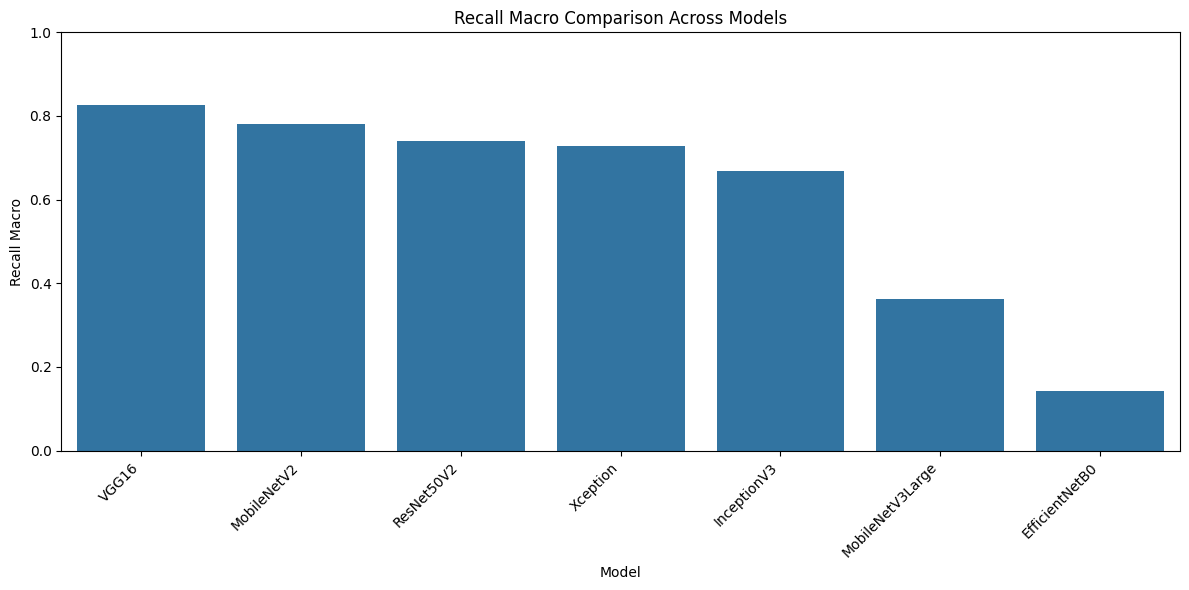

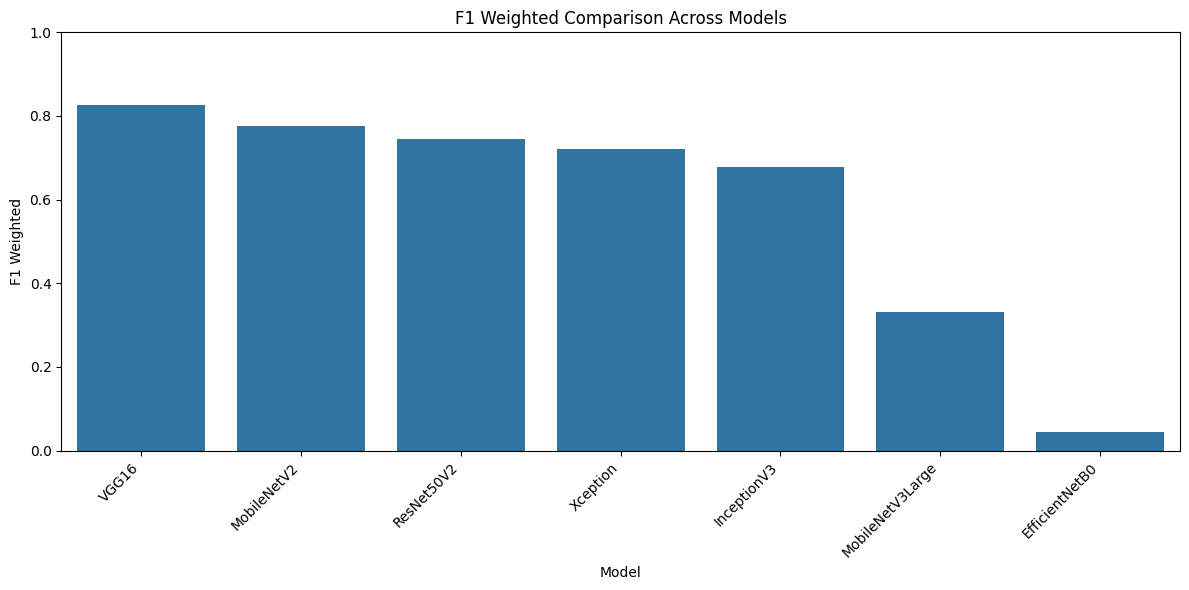

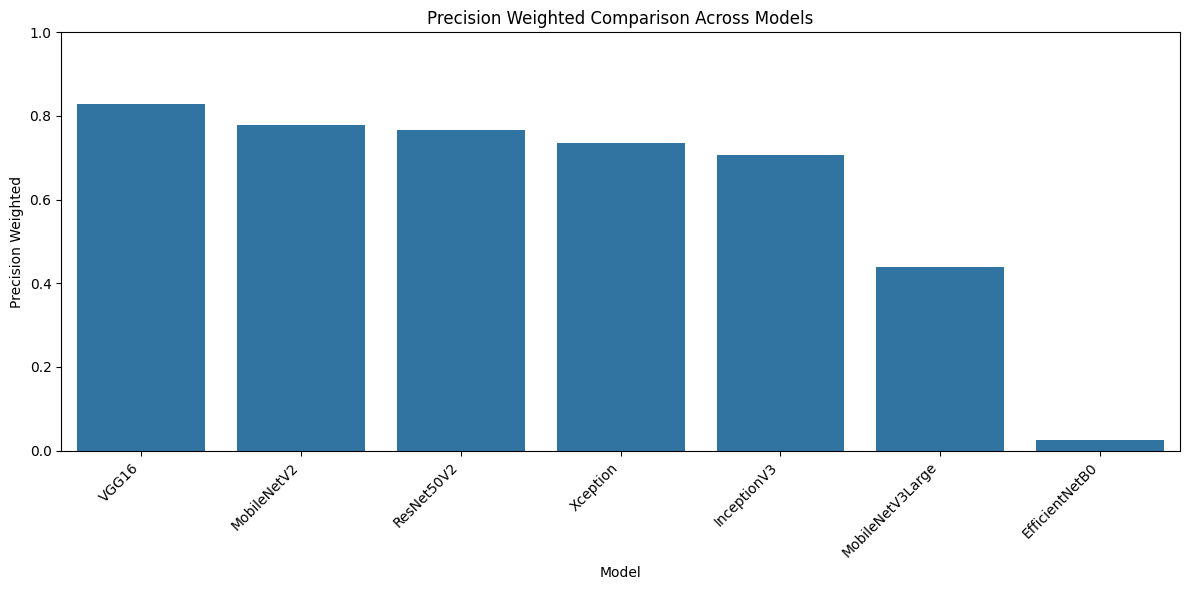

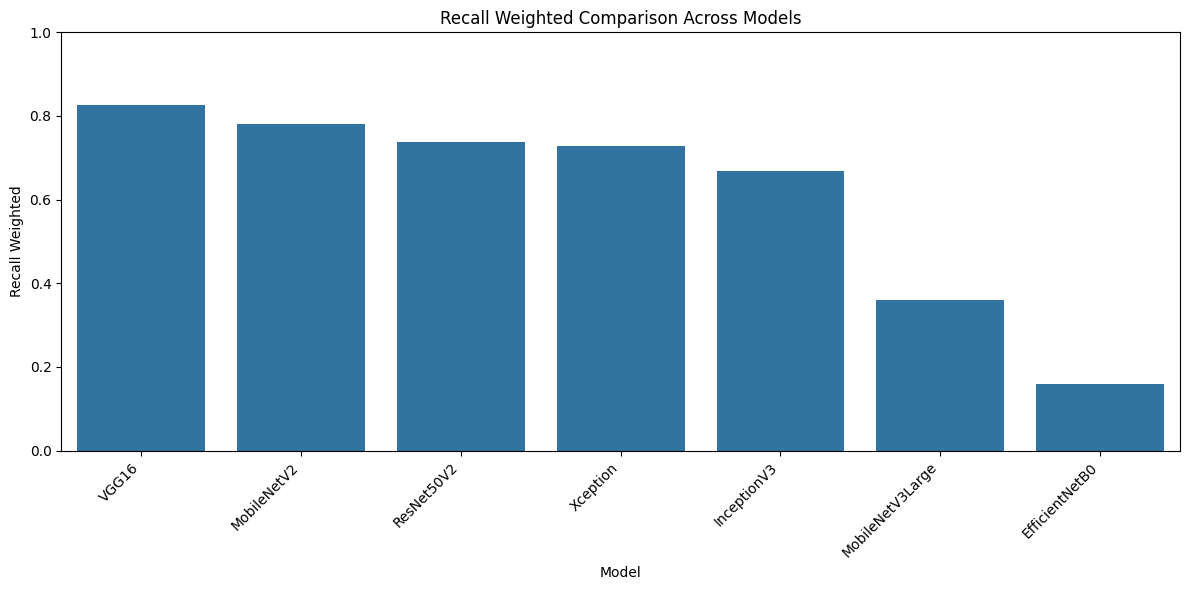

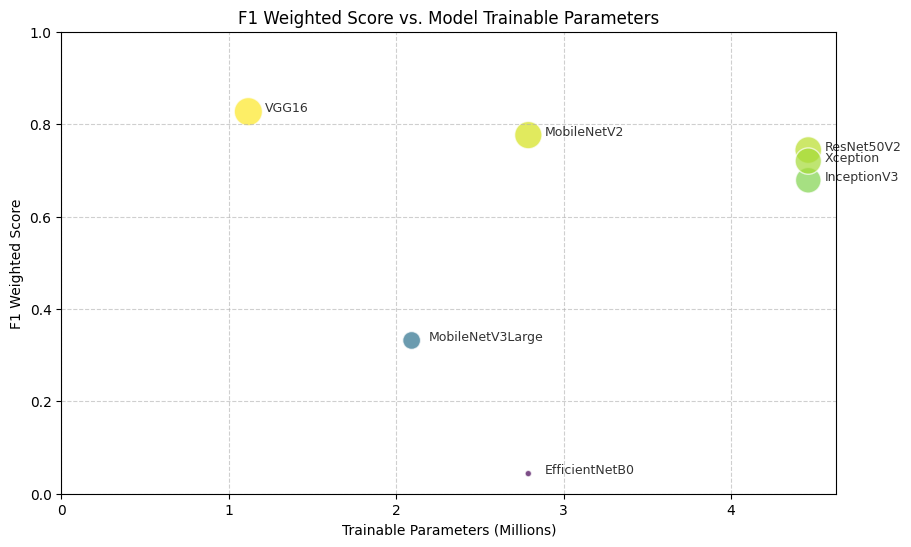

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define the path to the CSV file
results_csv_path = "/content/drive/MyDrive/Project/surgical_phase_recognition_model_evaluation_results.csv"

try:
    # Read the data from the CSV file
    df = pd.read_csv(results_csv_path)
    print(f"✅ Evaluation results loaded from: {results_csv_path}")
    print(df.columns)
except FileNotFoundError:
    print(f"Error: The file '{results_csv_path}' was not found.")
    # Handle the error, maybe skip plotting or use placeholder data
    df = pd.DataFrame() # Create an empty DataFrame to avoid errors later
except Exception as e:
    print(f"Error reading CSV file: {e}")
    df = pd.DataFrame() # Create an empty DataFrame to avoid errors later


if not df.empty:
    # Sort by F1 weighted for better visualization in the first plot
    df_sorted = df.sort_values(by='f1_weighted', ascending=False)

    # ----------------------------------------------------------------------
    ## Plotting available metrics
    # ----------------------------------------------------------------------

    metrics_to_plot = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro', 'f1_weighted', 'precision_weighted', 'recall_weighted']

    for metric in metrics_to_plot:
        plt.figure(figsize=(12, 6))
        sns.barplot(x='model', y=metric, data=df_sorted)
        plt.title(f'{metric.replace("_", " ").title()} Comparison Across Models')
        plt.xlabel('Model')
        plt.ylabel(metric.replace("_", " ").title())
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 1.0) # Assuming metrics are between 0 and 1
        plt.tight_layout()
        plt.show()

    # ----------------------------------------------------------------------
    ## Scatter plot of F1 Weighted vs. Trainable Parameters
    # ----------------------------------------------------------------------

    plt.figure(figsize=(10, 6))
    plt.scatter(
        df['trainable_params'] / 1e6, # Convert to millions for better readability
        df['f1_weighted'],
        s=df['f1_weighted'] * 500,  # Size based on F1 weighted
        c=df['f1_weighted'],        # Color based on F1 weighted
        cmap='viridis',
        alpha=0.7,
        edgecolors='w',
        linewidths=1
    )

    # Annotate each point with the model name
    for i, row in df.iterrows():
        plt.annotate(
            row['model'],
            (row['trainable_params'] / 1e6 + 0.1, row['f1_weighted']),
            fontsize=9,
            alpha=0.8
        )

    plt.xlabel('Trainable Parameters (Millions)')
    plt.ylabel('F1 Weighted Score')
    plt.title('F1 Weighted Score vs. Model Trainable Parameters')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(0)
    plt.ylim(0, 1.0)

    plt.savefig('model_efficiency_tradeoff.png')
    plt.show()
    plt.close()

else:
    print("DataFrame is empty. Cannot generate plots.")

✅ Evaluation results loaded from: /content/drive/MyDrive/Project/surgical_phase_recognition_model_evaluation_results.csv


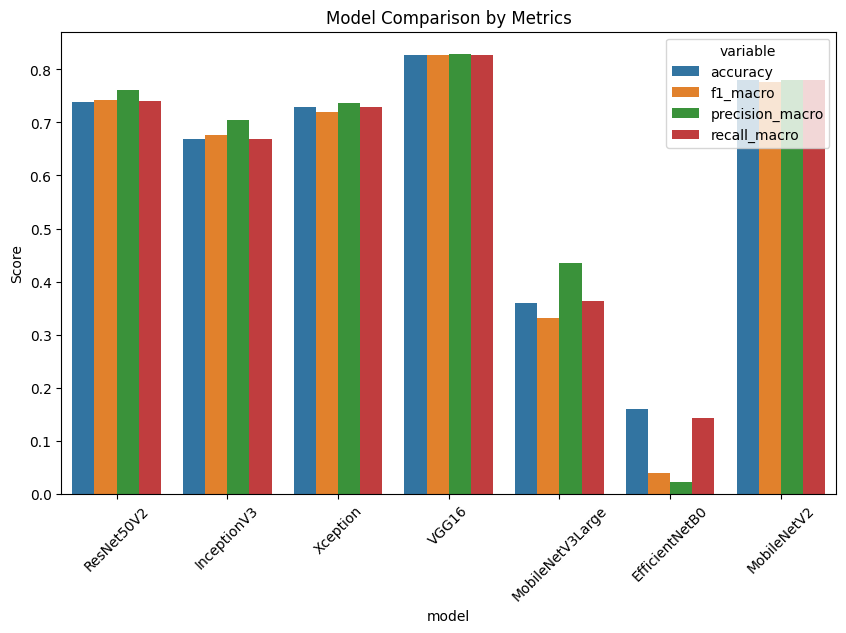

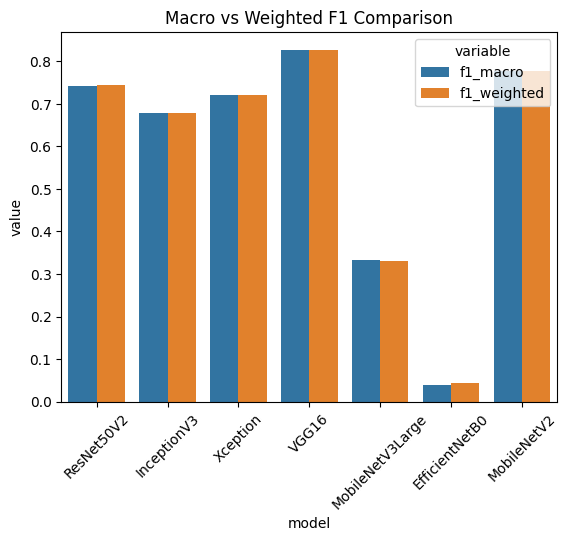

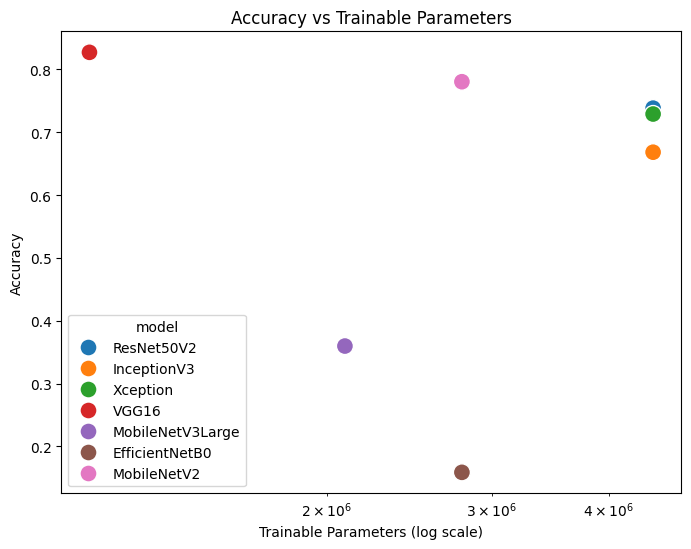

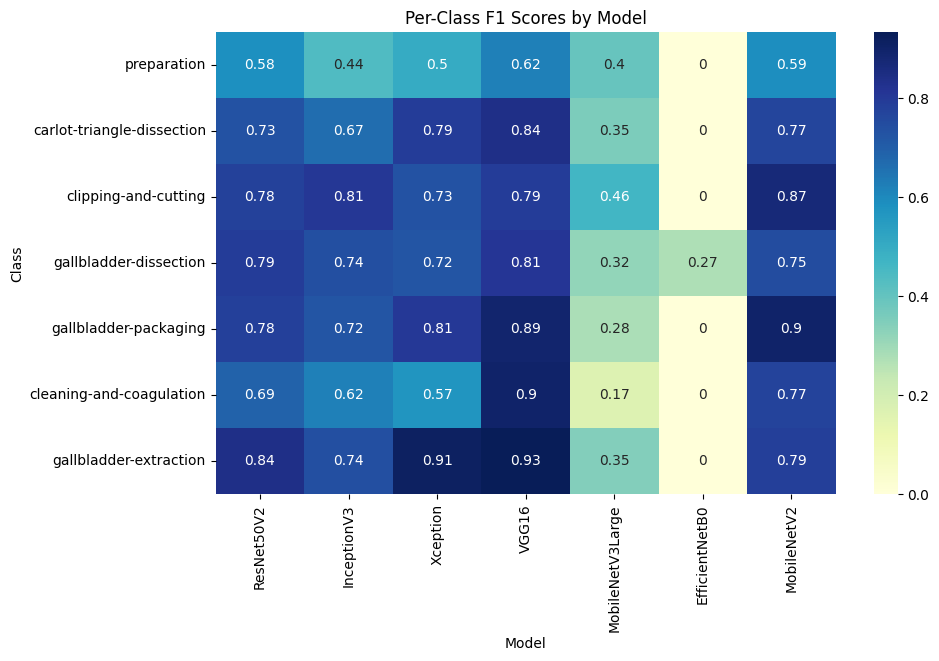

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define the path to the CSV file
results_csv_path = "/content/drive/MyDrive/Project/surgical_phase_recognition_model_evaluation_results.csv"

try:
    # Read the data from the CSV file
    df = pd.read_csv(results_csv_path)
    print(f"✅ Evaluation results loaded from: {results_csv_path}")
except FileNotFoundError:
    print(f"Error: The file '{results_csv_path}' was not found.")
    # Handle the error, maybe skip plotting or use placeholder data
    df = pd.DataFrame() # Create an empty DataFrame to avoid errors later
except Exception as e:
    print(f"Error reading CSV file: {e}")
    df = pd.DataFrame() # Create an empty DataFrame to avoid errors later


if not df.empty:
  # Assuming you have a DataFrame `df`
  metrics = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']

  plt.figure(figsize=(10,6))
  sns.barplot(data=df.melt(id_vars='model', value_vars=metrics),
              x='model', y='value', hue='variable')
  plt.title("Model Comparison by Metrics")
  plt.xticks(rotation=45)
  plt.ylabel("Score")
  plt.show()
# /////////////////////////////////////
  metrics_compare = ['f1_macro', 'f1_weighted']

  sns.barplot(data=df.melt(id_vars='model', value_vars=metrics_compare),
              x='model', y='value', hue='variable')
  plt.title("Macro vs Weighted F1 Comparison")
  plt.xticks(rotation=45)
  plt.show()
  # ////////////////////////////////
  plt.figure(figsize=(8,6))
  sns.scatterplot(data=df, x='trainable_params', y='accuracy', hue='model', s=150)
  plt.xscale('log')
  plt.title("Accuracy vs Trainable Parameters")
  plt.xlabel("Trainable Parameters (log scale)")
  plt.ylabel("Accuracy")
  plt.show()
  # //////////////////////////////////
  import json

  # Convert string reports to dicts
  df['classification_report'] = df['classification_report'].apply(lambda x: json.loads(x))

  # Extract F1 per class
  classes = list(df['classification_report'].iloc[0].keys())
  classes.remove('accuracy')
  classes.remove('macro avg')
  classes.remove('weighted avg')

  class_f1 = pd.DataFrame({
      model: [df.loc[df['model']==model, 'classification_report'].iloc[0][cls]['f1-score'] for cls in classes]
      for model in df['model']
  }, index=classes)

  plt.figure(figsize=(10,6))
  sns.heatmap(class_f1, annot=True, cmap='YlGnBu')
  plt.title("Per-Class F1 Scores by Model")
  plt.ylabel("Class")
  plt.xlabel("Model")
  plt.show()


